In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
from torch.utils.data import SubsetRandomSampler

# Load and Visualize Dataset

In [ ]:
transform=transforms.Compose([transforms.ToTensor()])
# To get the Normalization values do the follwing after downloading train data
# print(train_data.data.float().mean()/255)
# print(train_data.data.float().std()/255)
train_data=datasets.FashionMNIST('data',train=True,download=True,transform=transform)
test_data=datasets.FashionMNIST('data',train=False,download=True,transform=transform)

100%|██████████| 26421880/26421880 [00:00<00:00, 126910036.06it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 61254271.43it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 67285945.81it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22352253.61it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
train_length=len(train_data)

indices=[i for i in range(train_length)]
np.random.shuffle(indices)

split=int(np.floor(0.2*train_length))
train_idx=indices[split:]
valid_idx=indices[:split]

train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=20, sampler=train_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20,num_workers=0)

# This is for debugging
print(f"Training data size : {train_idx.__len__()}, Validation data size : {valid_idx.__len__()}, Test data size : {test_loader.dataset.__len__()}")

Training data size : 48000, Validation data size : 12000, Test data size : 10000


In [ ]:
# checking our data
dataiter=iter(train_loader)
images,labels=next(dataiter)
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

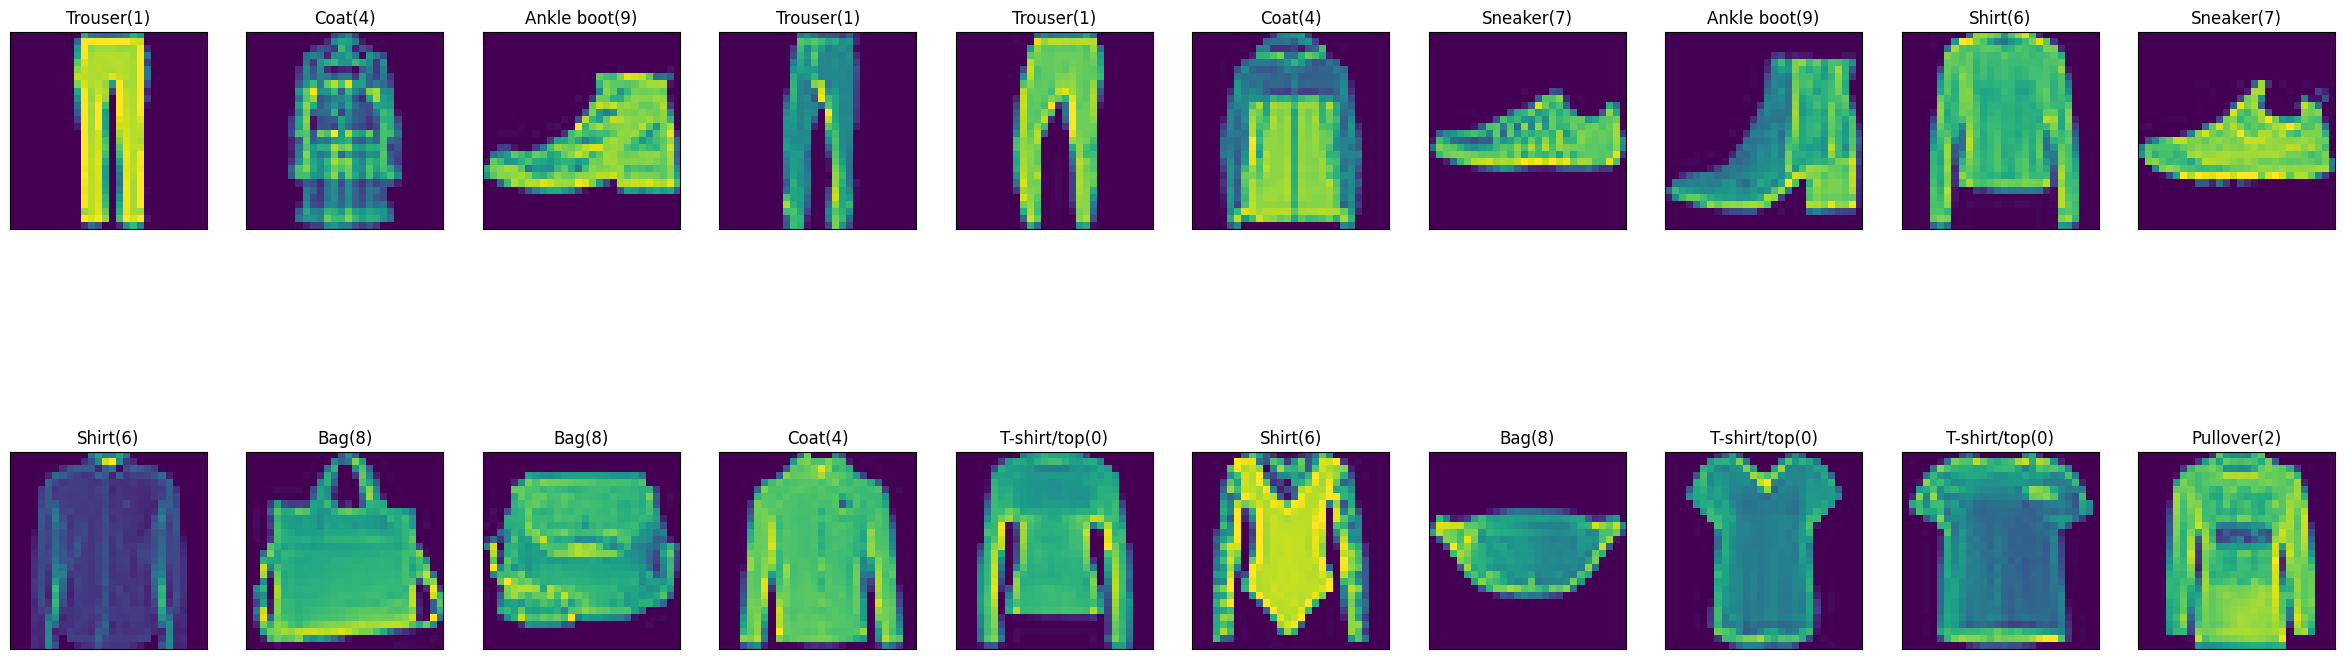

In [ ]:
fashion_class={
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(f"{fashion_class[labels[i].item()]}({labels[i].item()})")

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier,self).__init__()
    self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)


    self.fc1=nn.Linear(7*7*32,512)
    self.fc2=nn.Linear(512,256)
    self.out=nn.Linear(256,10)
    self.dropout=nn.Dropout(0.2)

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=x.view(-1,7*7*32)
    x = self.dropout(x)
    x=self.dropout(F.relu(self.fc1(x)))
    x=self.dropout(F.relu(self.fc2(x)))
    x=self.out(x)
    return x

In [ ]:
model=Classifier()
def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
model.apply(weight_init_normal)
use_cuda=True
if use_cuda and torch.cuda.is_available():
  model.cuda()


print(model,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

Classifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 On GPU :  True


In [ ]:
# Loss Function
# If we did not compute softmax at output use nn.CrossentropyLoss() else use nn.NLLLoss()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

# Number of epochs to train for
loss_keeper={'train':[],'valid':[],'accuracy':[]}
epochs=50
# minimum validation loss ----- set initial minimum to infinity
valid_loss_min = np.Inf
for epoch in range(epochs):
    train_loss=0.0
    valid_loss=0.0

    """
    TRAINING PHASE
    """
    model.train() # TURN ON DROPOUT for training
    for images,labels in train_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
        optimizer.zero_grad()
        output=model(images)
        loss=criterion(output,labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    """
    VALIDATION PHASE
    """
    model.eval() # TURN OFF DROPOUT for validation
    for images,labels in valid_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
        output=model(images)
        loss=criterion(output,labels)
        valid_loss+=loss.item()

    # Calculating loss over entire batch size for every epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # saving loss values
    loss_keeper['train'].append(train_loss)
    loss_keeper['valid'].append(valid_loss)

    print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")

    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
        z=type(model).__name__
        torch.save(model.state_dict(), z+'_model.pth')
        valid_loss_min=valid_loss


Epoch : 1	Training Loss : 0.4808727433804112	Validation Loss : 0.2998418980433295
Validation loss decreased from : inf ----> 0.2998418980433295 ----> Saving Model.......

Epoch : 2	Training Loss : 0.32075633550217997	Validation Loss : 0.24733730554425468
Validation loss decreased from : 0.2998418980433295 ----> 0.24733730554425468 ----> Saving Model.......

Epoch : 3	Training Loss : 0.2759882642759476	Validation Loss : 0.21426451990109247
Validation loss decreased from : 0.24733730554425468 ----> 0.21426451990109247 ----> Saving Model.......

Epoch : 4	Training Loss : 0.24716315110505094	Validation Loss : 0.19826107498724013
Validation loss decreased from : 0.21426451990109247 ----> 0.19826107498724013 ----> Saving Model.......

Epoch : 5	Training Loss : 0.22255117199897845	Validation Loss : 0.16202839520197207
Validation loss decreased from : 0.19826107498724013 ----> 0.16202839520197207 ----> Saving Model.......

Epoch : 6	Training Loss : 0.20355451037195357	Validation Loss : 0.1633

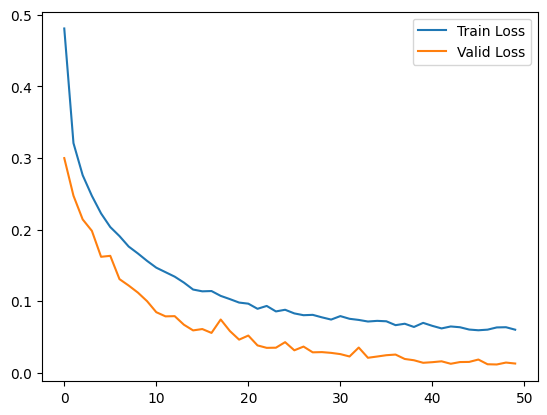

In [ ]:
plt.plot(loss_keeper['train'], label='Train Loss')
plt.plot(loss_keeper['valid'], label='Valid Loss')

plt.legend()

In [ ]:
print(model.state_dict)

<bound method Module.state_dict of Classifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>


In [ ]:
correct=0
test_loss=0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # test the model with dropout layers off
for images,labels in test_loader:
    if use_cuda and torch.cuda.is_available():
        images,labels=images.cuda(),labels.cuda()
    output=model(images)
    loss=criterion(output,labels)
    test_loss+=loss.item()
    _,pred=torch.max(output,1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss=test_loss/len(test_loader)
print(f'For {type(model).__name__} :')
print(f"Test Loss: {test_loss}")
print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
for i in range(10):
  if class_total[i] > 0:
      print(f"Test Accuracy of class {fashion_class[i]} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
  else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")


For Classifier :
Test Loss: 0.4360648348736045
Correctly predicted per class : [845.0, 983.0, 870.0, 927.0, 871.0, 979.0, 748.0, 981.0, 984.0, 968.0], Total correctly perdicted : 9156.0
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000.0

Test Accuracy of class T-shirt/top : 84.5% where 845 of 1000 were predicted correctly
Test Accuracy of class Trouser : 98.3% where 983 of 1000 were predicted correctly
Test Accuracy of class Pullover : 87.0% where 870 of 1000 were predicted correctly
Test Accuracy of class Dress : 92.7% where 927 of 1000 were predicted correctly
Test Accuracy of class Coat : 87.1% where 871 of 1000 were predicted correctly
Test Accuracy of class Sandal : 97.9% where 979 of 1000 were predicted correctly
Test Accuracy of class Shirt : 74.8% where 748 of 1000 were predicted correctly
Test Accuracy of class Sneaker : 98.1% where 981 of 1000 were predicted correctly
Test Accu

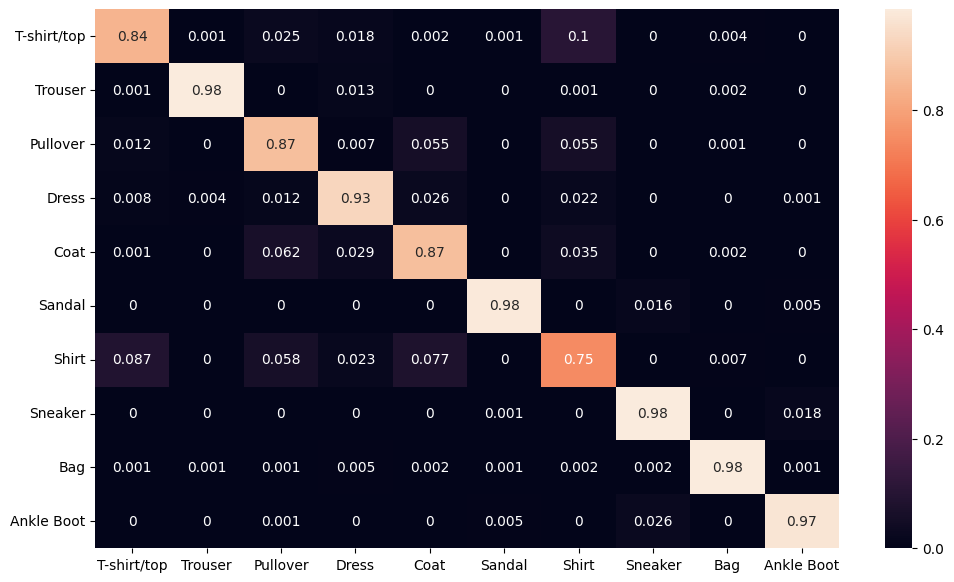

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for images, labels in test_loader:
        if use_cuda and torch.cuda.is_available():
          images,labels=images.cuda(),labels.cuda()
        output = model(images) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
import sklearn.metrics as metrics

print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(y_true, y_pred)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.85      0.87      0.86      1000
           3       0.91      0.93      0.92      1000
           4       0.84      0.87      0.86      1000
           5       0.99      0.98      0.99      1000
           6       0.77      0.75      0.76      1000
           7       0.96      0.98      0.97      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000




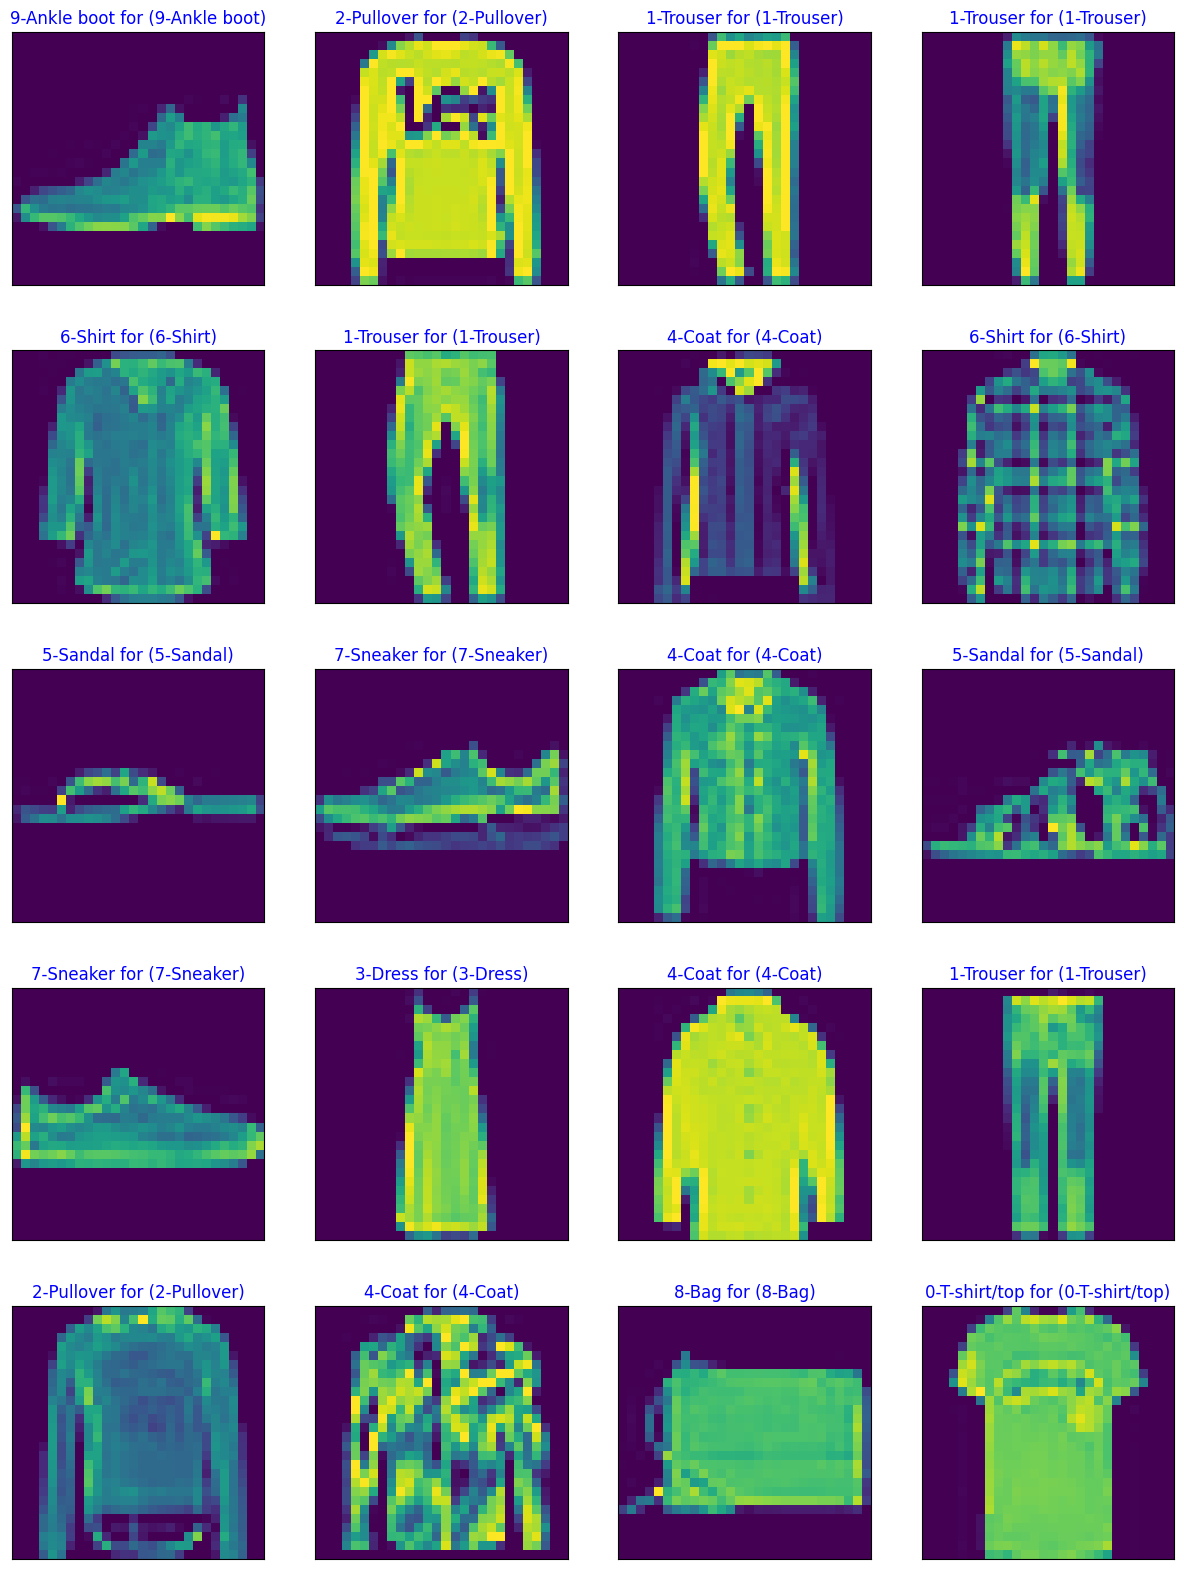

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
if use_cuda and torch.cuda.is_available():
  images,labels=images.cuda(),labels.cuda()
output = model(images)

# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()

fig = plt.figure(figsize=(15, 20))
for idx in np.arange(20):
    ax = fig.add_subplot(5, 20//5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(images[idx]))
    ax.set_title("{}-{} for ({}-{})".format(str(preds[idx].item()), fashion_class[preds[idx].item()],str(labels[idx].item()),fashion_class[labels[idx].item()]),
                color=("blue" if preds[idx]==labels[idx] else "red"))